# POS tagging
 


In [1]:
import numpy as np
import time

The following downloads some data and picks it apart to get it on a standard sklearn form. This is a famous data set that you should know about. You can read more on the dataset at https://en.wikipedia.org/wiki/Brown_Corpus.

In [2]:
import nltk
nltk.download('brown')
from nltk.corpus import brown
nltk.download('universal_tagset')

n_sentences = len(brown.tagged_sents(tagset='universal'))

X = list()
y = list()
for sentence in brown.tagged_sents(tagset='universal'):
  for n, pair in enumerate(sentence):
    word, tag = pair
    if n == 0:
      X.append([word])
      y.append([tag])
    else:
      X[-1].append(word)
      y[-1].append(tag)
assert len(X) == len(y)

print("Found %i sentences with %i instances" % (n_sentences, np.sum([len(x) for x in X])))
# print("Original data example:", brown.tagged_sents(tagset='universal')[0])
print("Processed sentences example:")
print("x_0: %s" % X[0])
print("y_0: %s" % y[0])

[nltk_data] Downloading package brown to /home/fredrik/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/fredrik/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


Found 57340 sentences with 1161192 instances
Processed sentences example:
x_0: ['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.']
y_0: ['DET', 'NOUN', 'NOUN', 'ADJ', 'NOUN', 'VERB', 'NOUN', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'NOUN', 'NOUN', 'VERB', '.', 'DET', 'NOUN', '.', 'ADP', 'DET', 'NOUN', 'VERB', 'NOUN', '.']


To be able to compare the models, the accuracy and train/test splits are defined here, before the tagger code.

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

def tag_accuracy(y, y_hat):
  accuracy = list()
  for u, v in zip(y, y_hat):
    accuracy.append(np.sum([e1==e2 for e1, e2 in zip(u, v)])/len(u))
  return accuracy

## A very naive tagger
 
This is a very naive tagger. It will tag a word with the most common POS tag in the training corpus. However, since getting an accuracy above 90% is not that hard for POS tagging, this can still impress someone not familiar with the problem formulation. If P(NOUN|'walk') < P(VERB|'walk') then the tag will be VERB in every instance.

In [4]:
class NaiveTagger:
  def __init__(self):
    """A very naive POS tagger"""
    pass
  
  def fit(self, X, y):
    self._unique_words = list()
    for x in X:
      self._unique_words.extend(x)
    self._unique_words = list(set(self._unique_words))

    self._unique_tags = list()
    for e in y:
      self._unique_tags.extend(e)
    self._unique_tags = list(set(self._unique_tags))

    self._unique_words_lut = dict()
    for i, word in enumerate(self._unique_words):
      self._unique_words_lut[word] = i

    self._unique_tags_lut = dict()
    for i, tag in enumerate(self._unique_tags):
      self._unique_tags_lut[tag] = i

    self.frequencies = np.zeros((len(self._unique_words), len(self._unique_tags)), dtype=np.int)

    for words, tags in zip(X, y):
      for word, tag in zip(words, tags):
        self.frequencies[self._unique_words_lut[word], self._unique_tags_lut[tag]] += 1

  def predict(self, X):
    majority_vote = naive_tagger._unique_tags[np.argmax(np.sum(naive_tagger.frequencies, axis=0))]
    ret = list()
    for words in X:
      tags = list()
      for word in words:
        if word in self._unique_words_lut:
          tags.append(self._unique_tags[np.argmax(self.frequencies[self._unique_words_lut[word], :])])
        else:
          tags.append(majority_vote)
      ret.append(tags)
    return ret

In [5]:
naive_tagger = NaiveTagger()
naive_tagger.fit(X_train, y_train)

y_hat = naive_tagger.predict(X_test)

accuracy = tag_accuracy(y_test, y_hat)
print("Mean accuracy: %.1f%% [std %.1f%%]" % (100*np.mean(accuracy), 100*np.std(accuracy)))

Mean accuracy: 94.5% [std 6.9%]


## Hidden markov model

The implementation of the decoding follows the wikipedia description
https://en.wikipedia.org/wiki/Viterbi_algorithm . If you want a more in depth description of the inner workings of an HMM, Rabiner's classic tutorial paper is a good start.

L. R. Rabiner, "*A tutorial on hidden Markov models and selected applications in speech recognition,*" in Proceedings of the IEEE, vol. 77, no. 2, pp. 257-286, Feb. 1989.
doi: 10.1109/5.18626


For the following model to work, we need to load the cython extension.


In [6]:
%load_ext cython

In [7]:
%%cython
import numpy as np

class POStagger:
  def __init__(self):
    """Simple HMM POS-tagger"""
    pass

  def fit(self, X, y):
    # Find unique words and tags
    unique_words = list()
    for words in X:
        unique_words.extend(words)
    unique_tags = list()
    for tags in y:
      unique_tags.extend(tags)
    self._unique_words = set(unique_words)
    self._unique_tags = set(unique_tags)
    # Making LUTs for indexing tags and words
    self._words_lut = dict()
    for n, word in enumerate(self._unique_words):
      self._words_lut[word] = n
    self._words_lut_inv = [None]*len(self._words_lut)
    for word, n in self._words_lut.items():
      self._words_lut_inv[n] = word
    self._tags_lut = dict()
    for n, tag in enumerate(self._unique_tags):
      self._tags_lut[tag] = n
    self._tags_lut_inv = [None]*len(self._tags_lut)
    for tag, n in self._tags_lut.items():
      self._tags_lut_inv[n] = tag
    assert np.all([e is not None for e in self._words_lut_inv])
    assert np.all([e is not None for e in self._tags_lut_inv])
    # print("Tags:", self._tags_lut)
    # print("Tags inverse:", self._tags_lut_inv)
    # print("Words:", repr(self._words_lut))
    # print("Words inverse:", repr(self._words_lut_inv))
    # Allocate matrices for key statistics (pi, A, B)
    self.n_states_ = len(self._tags_lut)
    self.n_words_ = len(self._words_lut)
    self.pi = np.zeros(self.n_states_)
    self.A = np.zeros((self.n_states_, self.n_states_))
    self.B = np.zeros((self.n_states_, self.n_words_))
    # Set prior
    self.pi[:] = 1/self.n_states_
    self.A[:] = 1/self.n_states_
    self.B[:] = 1/self.n_words_
    # Count occurences
    for words, tags in zip(X, y):
      for n, word, tag in zip(range(len(words)), words, tags):
        if n == 0:
          # Record start states 
          self.pi[self._tags_lut[tag]] += 1
        else:
          # Record tag transitions
          self.A[self._tags_lut[last_tag], self._tags_lut[tag]] += 1
        # Record word given tag occurences
        self.B[self._tags_lut[tag], self._words_lut[word]] += 1
        last_tag = tag
    # Normalize probabilities
    self.pi /= np.sum(self.pi)
    for i in range(self.A.shape[0]):
      self.A[i, :] /= np.sum(self.A[i, :])
    for i in range(self.B.shape[0]):
      self.B[i, :] /= np.sum(self.B[i, :])

  def predict(self, X):
    assert type(X) == list
    assert type(X[0]) == list
    return [t[0] for t in map(self._predict, X)]

  def _predict(self, sentence):
    assert type(sentence) == list
    cdef int i, j, k
    cdef int n_states = self.n_states_
    # Forward pass
    T1 = np.zeros((n_states, len(sentence)))
    cdef double[:,:] T1_memview = T1
    T2 = np.zeros(T1.shape, dtype=np.intc)
    cdef int[:,:] T2_memview = T2
    cdef double[:] pi_memview = self.pi
    cdef double[:,:] A_memview = self.A
    cdef double[:,:] B_memview = self.B
    cdef double p_max, w
    B_column = np.zeros(n_states, dtype=np.double)
    cdef double[:] B_column_memview = B_column
    for j, word in enumerate(sentence):
      if word in self._words_lut:
        word_idx = self._words_lut[word]
        for k in range(n_states):
          B_column_memview[k] = B_memview[k, word_idx]
      else:
        # If word is not in the training data, fall back to uniform probability
        w = 1/n_states
        for k in range(n_states):
          B_column_memview[k] = w
      # Special case for the first word in the sentence
      if j == 0:
        for i in range(n_states):
          T1_memview[i, j] = pi_memview[i]*B_column_memview[i]
      else:
        for i in range(n_states):
          p_max = 0
          for k in range(n_states):
            w = T1_memview[k, j-1]*A_memview[k, i]*B_column_memview[i]
            if w > p_max:
              p_max = w
              T1_memview[i, j] = w
              T2_memview[i, j] = k
    # Backward pass
    traceback = [np.argmax(T1[:, -1])]
    for i in range(len(sentence)-1, 0, -1):
      traceback.insert(0, T2[traceback[0], i])
    # print(output)
    assert len(traceback) == len(sentence)
    # Translate state numbers to tags and append to output
    return [self._tags_lut_inv[i] for i in traceback], T1, T2

In [8]:
hmm_tagger = POStagger()

t = time.time()
hmm_tagger.fit(X_train, y_train)
print("Training finished after %.1f seconds" % (time.time()-t))

t = time.time()
y_hat = hmm_tagger.predict(X_test)
t = time.time()-t
print("Prediction finished after %.1f seconds (%.1f μs/sentence)" % (t, 1e6*t/len(X_test)))

accuracy = tag_accuracy(y_test, y_hat)
print("Mean accuracy: %.1f%% [std %.1f%%]" % (100*np.mean(accuracy), 100*np.std(accuracy)))

Training finished after 1.1 seconds
Prediction finished after 0.3 seconds (24.7 μs/sentence)
Mean accuracy: 95.7% [std 7.1%]


The following is the code for illustrating the viterbi algorithm used in the slides.

/home/fredrik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


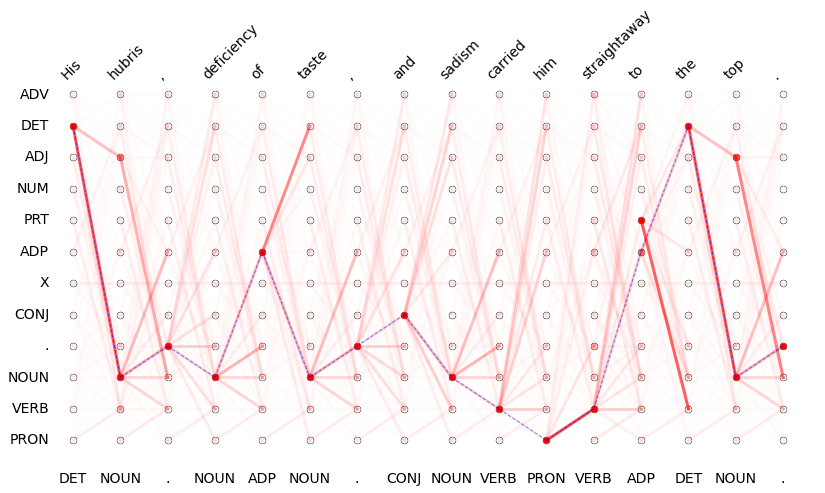

In [9]:
sentence = X[-20]
# tags = y[-1]
forward_pass = None
backward_pass = None
# def show_trellis(tagger, sentence, tags, forward_pass = None, backward_pass = None):

decoded_tags, T1, T2 = hmm_tagger._predict(sentence)
if forward_pass is None:
  forward_pass = list(range(len(T1[0])))
elif type(forward_pass) is int:
  forward_pass = list(range(forward_pass))
assert type(forward_pass) is list
if backward_pass is None:
  backward_pass = list(range(len(T1[0])))
elif type(backward_pass) is int:
  backward_pass = list(range(backward_pass, len(sentence)))
assert type(backward_pass) is list

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(int(len(sentence)*.9), int(hmm_tagger.n_states_*.6)))
ax = fig.add_subplot(1, 1, 1)
ax.invert_yaxis()

# Forward pass lines
for j, word in enumerate(sentence):
  if j in forward_pass and j > 0:
    w = np.asarray([T1[k][j-1] for k in range(hmm_tagger.n_states_)])
    w = .9*w/np.max(w) + .1
    for i in range(hmm_tagger.n_states_):
      for k in range(hmm_tagger.n_states_):
        # ax.plot([j, j-1], [i, k], 'r-', linewidth=3, alpha=w[k]*hmm_tagger.A[i][k])
        ax.plot([j-1, j], [k, i], 'r-', linewidth=3, alpha=w[k]*hmm_tagger.A[k][i])
# Plot the base
for i, state in enumerate(hmm_tagger._tags_lut_inv):
  ax.text(-.5, i, state, fontsize=14, horizontalalignment='right', verticalalignment='center')
  for j, word in enumerate(sentence):
    if i == 0:
      ax.text(j-.3, -.5, word, size=14, horizontalalignment='left', rotation=45)
    ax.scatter(j, i, c='k', s=40, marker='o')
    ax.scatter(j, i, c='w', s=30, marker='o')
ax.axis('off')
# Forward pass dots
for j, word in enumerate(sentence):
  w = np.asarray([T1[i][j] for i in range(hmm_tagger.n_states_)])
  w = w/np.max(w)
  if j in forward_pass:
    for i, state in enumerate(hmm_tagger._tags_lut_inv):
      ax.scatter(j, i, c='r', s=30, marker='o', alpha=w[i])
# Backward pass lines
i = np.argmax([T1[i][-1] for i in range(hmm_tagger.n_states_)])
for j in range(len(sentence)-1, -1, -1):
  if j in backward_pass and j > 0:
    ax.plot([j-1, j], [T2[i][j], i], 'b--', linewidth=1, alpha=.5)
  if j in backward_pass:
    ax.text(j, hmm_tagger.n_states_, hmm_tagger._tags_lut_inv[i], fontsize=14, horizontalalignment='center', verticalalignment='top')
  if j > 0:
    i = T2[i][j]
fig.show()

In [10]:
test_sentence = "We went for a walk ."

def tabbed_print(msg, data):
  print(msg, end="\t")
  for d in data:
    print(d.ljust(8), end="")
  print()

data = test_sentence.split()

tabbed_print("Test sentence:", data)
tabbed_print("Naive tagger:", naive_tagger.predict([data])[0])
tabbed_print("HMM sentence:", hmm_tagger.predict([data])[0])

Test sentence:	We      went    for     a       walk    .       
Naive tagger:	PRON    VERB    ADP     DET     VERB    .       
HMM sentence:	PRON    VERB    ADP     DET     NOUN    .       


In [11]:
assert "Xir" not in hmm_tagger._words_lut_inv
assert "xir" not in hmm_tagger._words_lut_inv

test_sentence = "Xir went for a walk ."

data = test_sentence.split()

tabbed_print("Test sentence:", data)
tabbed_print("Naive tagger:", naive_tagger.predict([data])[0])
tabbed_print("HMM sentence:", hmm_tagger.predict([data])[0])

Test sentence:	Xir     went    for     a       walk    .       
Naive tagger:	NOUN    VERB    ADP     DET     VERB    .       
HMM sentence:	PRON    VERB    ADP     DET     NOUN    .       


In [12]:
test_sentence = "colorless green dreams sleep furiously"

data = test_sentence.split()

tabbed_print("Test sentence:", data)
tabbed_print("Naive tagger:", naive_tagger.predict([data])[0])
tabbed_print("HMM sentence:", hmm_tagger.predict([data])[0])

Test sentence:	colorlessgreen   dreams  sleep   furiously
Naive tagger:	ADJ     ADJ     NOUN    NOUN    ADV     
HMM sentence:	ADJ     ADJ     NOUN    VERB    ADV     
